<a href="https://colab.research.google.com/github/veereshthotigar/CSEE5590-490-AI-CyberSecurity-/blob/master/Lab2/Same%20dataset%20(CIFAR10)%20but%20different%20architecture/Membership_Attack_part_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# required imports
import sys 
import numpy as np 
import matplotlib.pyplot as plt
%matplotlib inline  


import torch
import torchvision 
import torchvision.transforms as transforms
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data.sampler import SubsetRandomSampler

In [0]:
# mount the google drive to download the datasets
from google.colab import drive
drive.mount('/content/drive')
project_path = '/content/drive/My Drive/cybersecurity/Lab-Assignment-2/Part-2'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
# create transforms to load the images, nothing much is needed here. 
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

# Normalize the test set same as training set without augmentation
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

In [0]:
# download CIFAR 10 training set
trainset = torchvision.datasets.CIFAR10(root= project_path+'/data', train=True,
                                        download=True, transform=transform_train)

# load the trainning set
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True)

# download the test data
testset = torchvision.datasets.CIFAR10(root= project_path+'/data', train=False,
                                        download=True, transform=transform_test)

# load the test data
testloader = torch.utils.data.DataLoader(testset, batch_size=4, shuffle=True)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
# check those manually on the dataset site: https://www.cs.toronto.edu/~kriz/cifar.html 

0it [00:00, ?it/s]

170500096it [00:06, 27458524.47it/s]                               


Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


plane plane  deer truck


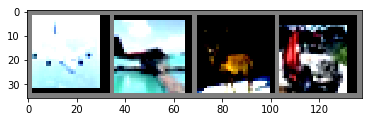

In [0]:
# helper function to unnormalize and plot image 
def imshow(img):
    img = np.array(img)
    img = img / 2 + 0.5
    img = np.moveaxis(img, 0, -1)
    plt.imshow(img)
    
# display sample from dataset 
imgs, labels = iter(trainloader).next()
imshow(torchvision.utils.make_grid(imgs)) 

# notice who we converted the class idx to labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

# run this cell multiple times and notice diff images

In [0]:
# divide the training dataset into the required groups Make sure they are balanced
# original trainset is made of 50k images

total_size = len(trainset)
split1 = total_size // 4
split2 = split1 * 2
split3 = split1 * 3

print(total_size, split1, split2, split3)

indices = list(range(total_size))

# two groups to train the shadow (in and out)
shadow_train_idx = indices[:split1]
shadow_out_idx = indices[split1:split2]

# two groups to train the Target (in and out)
target_train_idx = indices[split2:split3]
target_out_idx =  indices[split3:]


50000 12500 25000 37500


In [0]:
batch_size = 10# pick your own

# divide and load shadow train in and out
shadow_train_sampler = SubsetRandomSampler(shadow_train_idx) # Pytorch function
shadow_train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, sampler=shadow_train_sampler)

shadow_out_sampler = SubsetRandomSampler(shadow_out_idx) # Pytorch function
shadow_out_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, sampler=shadow_out_sampler)

# divide and load Target in and out
target_train_sampler = SubsetRandomSampler(target_train_idx) # Pytorch function
target_train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, sampler=target_train_sampler)

target_out_sampler = SubsetRandomSampler(target_out_idx) # Pytorch function
target_out_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, sampler=target_out_sampler)


In [0]:
def load_checkpoint(filepath):
    checkpoint = torch.load(filepath)
    model = CNN()
    model.load_state_dict(checkpoint)
    
    return model

Below is the preTrained Target Model loading

In [0]:
#load the model
load_target_model = load_checkpoint(project_path+'/../../target_checkpoint.pth')
load_target_model = load_target_model.cuda()

# freeze the Target model 
for param in load_target_model.parameters():
    param.requires_grad = False

Below is Shadow Model Architecture different from target model

In [0]:
#@title
# Shadow Model Architecture
# Input shape (3, 32, 32) 
# architecture: simple. 2 conv and 2 Max pool, followed by 2 fc (120, 84) 
# output of fc is 10 because we have 10 classes!



class shadow(nn.Module):
    """CNN."""

    def __init__(self):
        """CNN Builder."""
        super(shadow, self).__init__()

        self.fc_layer = nn.Sequential(
            nn.Linear(3*32*32, 2304),
            nn.ReLU(inplace=True),
            nn.Linear(2304, 1536),
            nn.ReLU(inplace=True),
            nn.Linear(1536, 1024),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.1),
            nn.ReLU(inplace=True),
            nn.Linear(1024, 768),
            nn.ReLU(inplace=True),
            nn.Linear(768, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.1),
            nn.Linear(512, 10),
            nn.LogSoftmax(dim=1)
        )


    def forward(self, x):
        """Perform forward."""
        x = x.view(x.shape[0], -1)
        # fc layer
        x = self.fc_layer(x)

        return x

In [0]:
# check if CUDA available or not
print(torch.cuda.is_available())
print(torch.cuda.get_device_name(0))
# clear the cache
torch.cuda.empty_cache()

True
Tesla K80


In [0]:
# initalize a Shadow Model and Train it
shadow_model = shadow()
# clear the cache
torch.cuda.empty_cache()
#send to GPU
shadow_model = shadow_model.cuda()
shadow_criterion =  nn.CrossEntropyLoss() # CrossEntropyLoss
shadow_optimizer = optim.Adam(shadow_model.parameters(), lr=0.003) # ADAM 
# let the magic begin
epochs = 20
with torch.set_grad_enabled(True):
  for e in range(epochs):
      running_loss = 0
      for images, labels in shadow_train_loader:
          # sending tensors to GPU
          images = images.cuda()
          labels = labels.cuda()
          shadow_optimizer.zero_grad()
          logits = shadow_model(images)
          shadow_loss = shadow_criterion(logits, labels)
          shadow_loss.backward()
          shadow_optimizer.step()


          running_loss += shadow_loss.item()
      else:
          print("\nEpoch : {}/{}..".format(e+1,epochs),f"Training loss: {running_loss/len(shadow_train_loader)}")

#save the model
print("Our model: \n\n", shadow_model, '\n')
torch.save(shadow_model.state_dict(), project_path+'/shadow_checkpoint.pth')
print('Finished Training the Shadow model')


Epoch : 1/40.. Training loss: 2.35042440612793

Epoch : 2/40.. Training loss: 2.303900334625244

Epoch : 3/40.. Training loss: 2.303753274002075

Epoch : 4/40.. Training loss: 2.3037507942962647

Epoch : 5/40.. Training loss: 2.3040810263824465

Epoch : 6/40.. Training loss: 2.3039118954467774

Epoch : 7/40.. Training loss: 2.3037847388458252

Epoch : 8/40.. Training loss: 2.3325814567184446

Epoch : 9/40.. Training loss: 2.3035141457366946

Epoch : 10/40.. Training loss: 2.303568374710083

Epoch : 11/40.. Training loss: 2.3034756452941894

Epoch : 12/40.. Training loss: 2.3038089839935303

Epoch : 13/40.. Training loss: 2.3037385453033448

Epoch : 14/40.. Training loss: 2.303823454208374

Epoch : 15/40.. Training loss: 2.303901102523804

Epoch : 16/40.. Training loss: 2.303787969894409

Epoch : 17/40.. Training loss: 2.303529346008301

Epoch : 18/40.. Training loss: 2.303608746414185

Epoch : 19/40.. Training loss: 2.3037585190582277

Epoch : 20/40.. Training loss: 2.303129225616455


In [0]:
# calculate the accuracy of the Shadow Model
correct = 0
total = 0

with torch.no_grad():
    for images, labels in shadow_out_loader:
        # sending tensors to GPU
        images = images.cuda()
        labels = labels.cuda()
        outputs = shadow_model(images)
        _, predicted = torch.max(outputs.data, 1)
        #print(predicted)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the {len(shadow_out_loader)*batch_size} test images: %d %%' % (100 * correct / total))

Accuracy of the network on the 12500 test images: 9 %


In [0]:
#creating dataset for attack model
batch_size = 1

# divide and load shadow train in and out
shadow_train_sampler = SubsetRandomSampler(shadow_train_idx) # Pytorch function
shadow_train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, sampler=shadow_train_sampler)

shadow_out_sampler = SubsetRandomSampler(shadow_out_idx) # Pytorch function
shadow_out_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, sampler=shadow_out_sampler)

# divide and load Target in and out
target_train_sampler = SubsetRandomSampler(target_train_idx) # Pytorch function
target_train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, sampler=target_train_sampler)

target_out_sampler = SubsetRandomSampler(target_out_idx) # Pytorch function
target_out_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, sampler=target_out_sampler)

In [0]:
#load the model
load_shadow_model = load_checkpoint(project_path+'/shadow_checkpoint.pth')
load_shadow_model = load_shadow_model.cuda()

# freeze the Shadow model 
for param in load_shadow_model.parameters():
    param.requires_grad = False
    
# make predictions on both datasets (shadow_in and shdow_out)
predictions = []

labels_0 = 0#np.zeros(1)
labels_1 = 1#np.ones(1)

with torch.no_grad():
    for images, labels in shadow_train_loader:
        # sending tensors to GPU
        images = images.cuda()
        labels = labels.cuda()
        logps = load_shadow_model(images)
        ps = torch.exp(logps) 
        ps = ps.cpu()
        pred = ps.data.numpy()
        predictions.append([pred[0],labels_1])   
with torch.no_grad():
    for images, labels in shadow_out_loader:
        # sending tensors to GPU
        images = images.cuda()
        labels = labels.cuda()
        logps = load_shadow_model(images)
        ps = torch.exp(logps) 
        ps = ps.cpu()
        pred = ps.data.numpy()
        predictions.append([pred[0],labels_0]) 
        
print(predictions[0])  
print(predictions[13000]) 


[array([0.69812787, 0.0056684 , 0.04928311, 0.06875259, 0.00446699,
       0.08649439, 0.00238252, 0.03545161, 0.01053014, 0.03884223],
      dtype=float32), 1]
[array([2.3185348e-06, 1.8340063e-05, 1.9232699e-03, 2.8209519e-03,
       1.4139616e-02, 3.7749086e-02, 9.4329131e-01, 4.7475736e-05,
       7.2393818e-06, 7.3020817e-07], dtype=float32), 0]


In [0]:
# create a new dataset of the shape [predictions(shadow_in), 1], [predicitons(shadow_out), 0] and zip them together
#save the dataset
import pickle

with open(project_path+'/data/shadow.data', 'wb') as filehandle:
    pickle.dump(predictions, filehandle)


In [0]:
# calculate the recall and precision of your attack network using the Target_out and Target_in datasets
# to do so, take a random numer of datapoints, run them throw the target model,
    
# make predictions on both datasets (target_in and target_out)
predictions = []
label_size = (1,1)

labels_0 = 0
labels_1 = 1
with torch.no_grad():
    for images, labels in target_train_loader:
        # sending tensors to GPU
        images = images.cuda()
        labels = labels.cuda()
        logps = load_target_model(images)
        ps = torch.exp(logps) 
        ps = ps.cpu()
        pred = ps.data.numpy()
        predictions.append([pred[0],labels_1])   
with torch.no_grad():
    for images, labels in target_out_loader:
        # sending tensors to GPU
        images = images.cuda()
        labels = labels.cuda()
        logps = load_target_model(images)
        ps = torch.exp(logps) 
        ps = ps.cpu()
        pred = ps.data.numpy()
        predictions.append([pred[0],labels_0]) 
        
#save the dataset
import pickle

with open(project_path+'/data/target.data', 'wb') as filehandle:
    pickle.dump(predictions, filehandle)


In [0]:
#load the dataset
with open(project_path+'/data/target.data', 'rb') as filehandle:
    # read the data as binary data stream
    testloader = pickle.load(filehandle)

Continued in part - 2